In [1]:
# inspired from: A deep understanding of deep learning


import numpy as np


import torch
import torch.nn as nn

import sys

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

# %matplotlib widget
%matplotlib notebook
%matplotlib inline


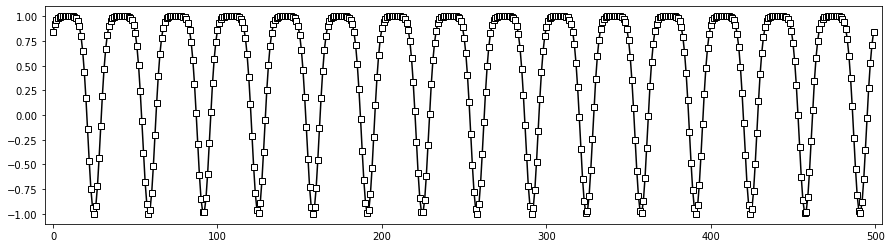

In [2]:
N = 500

time = torch.linspace(0,30*np.pi,N)
data = torch.sin(time+torch.cos(time))

plt.figure(figsize=(15,4))
plt.plot(data,'ks-',markerfacecolor='w')
plt.xlim([-5,N+4])
plt.show()

In [3]:
class rnnnet(nn.Module):
  def __init__(self):
    super().__init__()

    self.rnn = nn.RNN(input_size,num_hidden,num_layers)
    
    self.out = nn.Linear(num_hidden,1)
  


  def forward(self, x, h):
    
    y,hidden = self.rnn(x,h)
    
    y = self.out(y)
    

    return y,hidden.detach()



In [4]:
input_size =  1
num_hidden =  9
num_layers =  1
seqlength  = 30
batchsize  =  1

net = rnnnet()

X = torch.rand(seqlength,batchsize,input_size)

y,h = net(X,None) # None is for empty hidden state input

print(X.shape)
print(y.shape) # note: one output per sequence element; generally, we take the final output to force a "many-to-one" design.
print(h.shape)

torch.Size([30, 1, 1])
torch.Size([30, 1, 1])
torch.Size([1, 1, 9])


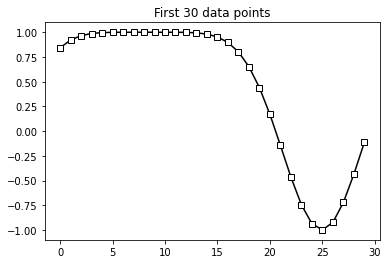

In [5]:
plt.plot(data[:seqlength],'ks-',markerfacecolor='w')
plt.title(f'First {seqlength} data points')
plt.show()

In [6]:
somedata = data[:seqlength].view(seqlength,1,1)
y = net(somedata,None)

# grab the final predicted value from the output (first element of tuple output of net)
finalValue = y[0][-1]

lossfun = nn.MSELoss()
lossfun(finalValue,data[seqlength].view(1,1))

tensor(0.0823, grad_fn=<MseLossBackward0>)

In [7]:
numepochs = 30

net = rnnnet()
optimizer = torch.optim.SGD(net.parameters(),lr=.001)



losses = np.zeros(numepochs)
signaccuracy = np.zeros(numepochs)

for epochi in range(numepochs):

  seglosses = []
  segacc    = []
  hiddenstate = None

  for timei in range(N-seqlength):

    X = data[timei:timei+seqlength].view(seqlength,1,1)
    y = data[timei+seqlength].view(1,1)

    yHat,hiddenstate = net(X,hiddenstate)
    finalValue = yHat[-1]
    loss = lossfun(finalValue,y) # compare final value of output

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss from this segment
    seglosses.append(loss.item())
  

  losses[epochi] = np.mean(seglosses)


  msg = f'Finished epoch {epochi+1}/{numepochs}'
  sys.stdout.write('\r' + msg)
  

Finished epoch 30/30

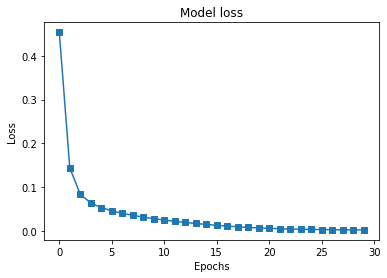

In [8]:
plt.plot(losses,'s-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model loss')

plt.show()

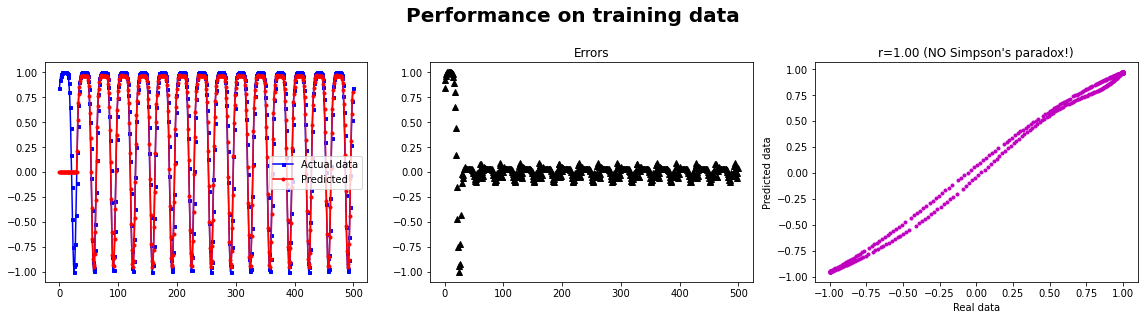

In [9]:
h = np.zeros((N,num_hidden))

yHat = np.zeros(N)
hh = None
for timei in range(N-seqlength):

  X = data[timei:timei+seqlength].view(seqlength,1,1)

  yy,hh = net(X,hh)
  yHat[timei+seqlength] = yy[-1]
  h[timei+seqlength,:] = hh.detach()



fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(data,'bs-',label='Actual data',markersize=3)
ax[0].plot(yHat,'ro-',label='Predicted',markersize=3)
ax[0].set_ylim([-1.1,1.1])
ax[0].legend()

ax[1].plot(data-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('Errors')

ax[2].plot(data[seqlength:],yHat[seqlength:],'mo',markersize=3)
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(data[seqlength:],yHat[seqlength:])
ax[2].set_title(f"r={r[0,1]:.2f} (NO Simpson's paradox!)")

plt.suptitle('Performance on training data',fontweight='bold',fontsize=20,y=1.1)
plt.tight_layout()
plt.show()

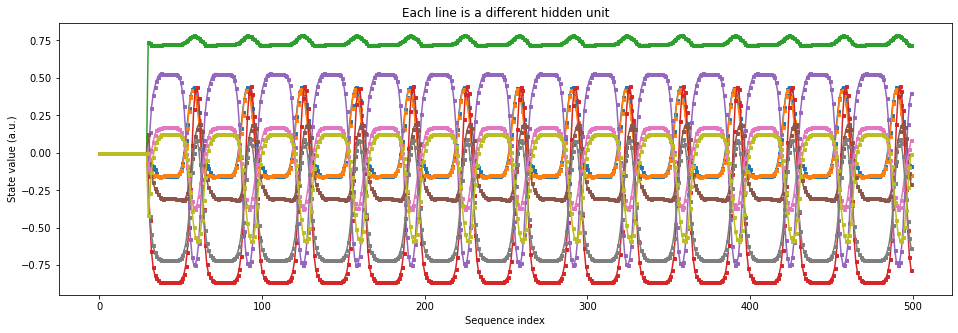

In [10]:
# show the hidden "states" (units activations)

plt.figure(figsize=(16,5))

plt.plot(h,'s-',markersize=3)
plt.xlabel('Sequence index')
plt.ylabel('State value (a.u.)')
plt.title('Each line is a different hidden unit')
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/lib/stride_tricks.py:536: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/usr/local/lib/python3.7/dist-packages/numpy/lib/stride_tricks.py:536: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]


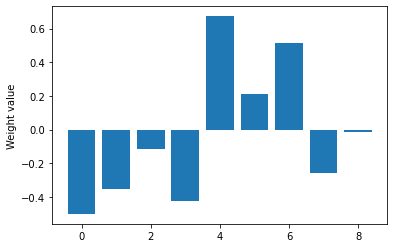

In [11]:
# plot the weights for the input --> hidden layers

plt.bar(range(num_hidden),net.rnn.weight_ih_l0.detach())
plt.ylabel('Weight value')
plt.show()

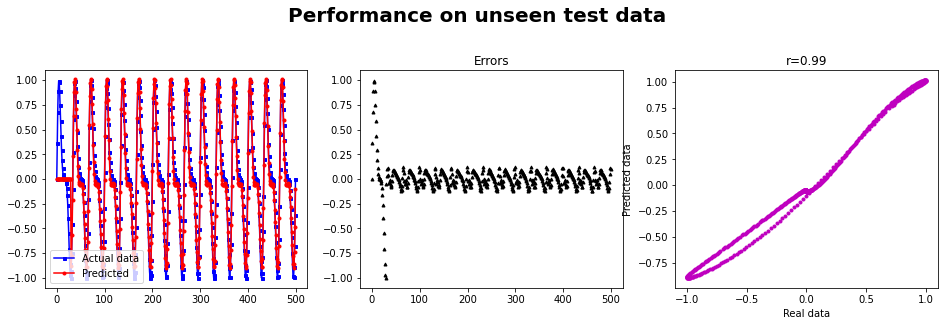

In [12]:
## Create new data (orange case: different frequency)
time = torch.linspace(0,10*np.pi,N)
newdata = torch.sin(time+torch.cos(time))

# Create new data (red case: different function)
time = torch.linspace(0,30*np.pi,N)
newdata = torch.sin(time+torch.sin(time))



# loop over time and predict each subsequent value
yHat = np.zeros(N)
h = None

for timei in range(N-seqlength):

  X = newdata[timei:timei+seqlength].view(seqlength,1,1)

  yy,h = net(X,h)
  yHat[timei+seqlength] = yy[-1]


fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(newdata,'bs-',label='Actual data',markersize=3)
ax[0].plot(yHat,'ro-',label='Predicted',markersize=3)
ax[0].set_ylim([-1.1,1.1])
ax[0].legend()

ax[1].plot(newdata-yHat,'k^',markersize=3)
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('Errors')

ax[2].plot(newdata[seqlength:],yHat[seqlength:],'mo',markersize=3)
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(newdata[seqlength:],yHat[seqlength:])
ax[2].set_title(f"r={r[0,1]:.2f}")

plt.suptitle('Performance on unseen test data',fontweight='bold',fontsize=20,y=1.1)
plt.show()

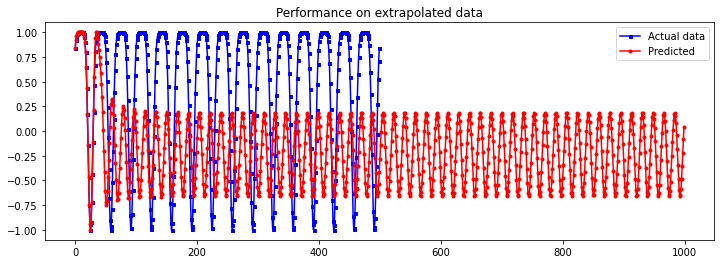

In [13]:
# using original data

# create a signal 2x as long
yHat = torch.zeros(2*N) # torch, not np!
yHat[:N] = data
h = None

for timei in range(2*N-seqlength):

  # grab a snippet of data
  X = yHat[timei:timei+seqlength].view(seqlength,1,1)
  
  yy,h = net(X,h)
  yHat[timei+seqlength] = yy[-1]



# convert back to np for plotting
yHat = yHat.detach()

fig = plt.figure(figsize=(12,4))
plt.plot(data,'bs-',label='Actual data',markersize=3)
plt.plot(yHat,'ro-',label='Predicted',markersize=3)
plt.ylim([-1.1,1.1])
plt.legend()
plt.title('Performance on extrapolated data')
plt.show()